In [147]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [148]:
def read_h5_file(output_file):
    simulation_data = {}
    with h5py.File(output_file, 'r') as f:
        # Read global attributes safely
        attributes = {
            "total_chicken_population": f.attrs.get("total_chicken_population", None),
            "duck_symptomatic_probability": f.attrs.get("duck_symptomatic_probability", None),
            "rescale_factor": f.attrs.get("rescale_factor", None)
        }

        # Iterate over simulation groups
        for sim_name in f:
            sim_group = f[sim_name]
            
            if "time" in sim_group and "state" in sim_group:
                t = sim_group["time"][:]
                y = sim_group["state"][:]
                simulation_data[sim_name] = {"time": t, "state": y}
            else:
                print(f"Warning: Missing 'time' or 'state' in {sim_name}")

    return simulation_data, attributes

In [149]:
def if_outbreak(t, y, outbreak_threshold=5):
    """Determine if an outbreak occurs based on the final time step."""
    return np.sum(y[-1, :, :, 5:]) >= outbreak_threshold

In [150]:
def passive_surveillance(t, y, alert_threshold=2):
    """Find the first time passive surveillance detects an outbreak."""
    threshold_reached = np.where(np.sum(y[:, :, :, 6], axis=(1, 2)) >= alert_threshold)[0]

    if len(threshold_reached) > 0:
        return t[threshold_reached[0]], np.trapz(np.sum(y[:threshold_reached[0]+1, :, :, 3:5], axis=(1, 2, 3)), t[:threshold_reached[0]+1])
    else:
        return np.nan, np.nan


In [151]:
def create_df(simulation_data):
    """Create a DataFrame summarizing outbreak and detection times and store associated states."""
    results = []

    for sim_name, data in simulation_data.items():
        outbreak = if_outbreak(data["time"], data["state"])
        
        pas_2, y2 = passive_surveillance(data["time"], data["state"], alert_threshold=2)
        pas_4, y4 = passive_surveillance(data["time"], data["state"], alert_threshold=4)
        pas_6, y6 = passive_surveillance(data["time"], data["state"], alert_threshold=6)
        
        final_deaths = np.sum(data["state"][-1, :, :, 6:])
        final_removed = np.sum(data["state"][-1, :, :, 5:])

        results.append([sim_name, outbreak, pas_2, y2, pas_4, y4, pas_6, y6, final_deaths, final_removed])

    # Create DataFrame
    df = pd.DataFrame(results, columns=[
        "simulation", "outbreak", 
        "passive_surveillance_threshold_2", "y2_state", 
        "passive_surveillance_threshold_4", "y4_state", 
        "passive_surveillance_threshold_6", "y6_state",
        "final_deaths", "final_removed"
    ])

    # Convert detection time columns to numeric
    for col in ["passive_surveillance_threshold_2", "passive_surveillance_threshold_4", "passive_surveillance_threshold_6"]:
        df[col] = pd.to_numeric(df[col], errors="coerce")  # Ensures NaNs are properly handled

    return df

In [152]:
# List of files corresponding to different chicken populations
chicken_levels = [0, 10, 20, 30, 40]
symprob = 0.8
rescale = 3.0
file_template = "Time_Series/chicken_{}_symprob_{}_rescale_{}.h5"

def process_files(chicken_levels, symprob=symprob):
    all_results = []

    for chicken in chicken_levels:
        output_file = file_template.format(chicken, symprob, rescale)
        simulation_data, attributes = read_h5_file(output_file)  # Read H5 file

        df = create_df(simulation_data)  # Create DataFrame
        df["chicken_population"] = chicken  # Add chicken level info

        all_results.append(df)  # Append to results list

    # Combine all into a single DataFrame
    combined_df = pd.concat(all_results, ignore_index=True)
    return combined_df

# Run the function
df_all = process_files(chicken_levels)


In [153]:

df_all.head(20)

,simulation,outbreak,passive_surveillance_threshold_2,y2_state,passive_surveillance_threshold_4,y4_state,passive_surveillance_threshold_6,y6_state,final_deaths,final_removed,chicken_population
0,simulation_1,False,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0
1,simulation_10,True,1.568868,9.954622,1.774969,14.261566,2.308987,28.939453,20.0,40.0,0
2,simulation_100,True,2.053878,25.919396,2.298588,33.552974,3.167790,62.491238,21.0,40.0,0
3,simulation_1000,True,1.951380,4.632597,3.017540,24.557806,3.728156,46.920018,25.0,40.0,0
4,simulation_1001,True,2.500392,17.159145,3.543278,49.425959,4.173187,68.590327,21.0,40.0,0
5,simulation_1002,True,1.781403,22.559345,2.098941,33.968692,2.291681,40.502207,28.0,40.0,0
6,simulation_1003,True,1.463594,8.305385,1.686724,12.497143,2.011357,18.908762,21.0,40.0,0
7,simulation_1004,True,1.977465,20.362426,2.448924,31.755243,3.229678,52.923047,19.0,40.0,0
8,simulation_1005,True,2.230496,28.504343,2.481568,36.444963,3.029990,52.746010,19.0,40.0,0
9,simulation_1006,True,1.799305,23.897822,2.598466,50.444299,3.093242,65.958988,28.0,40.0,0


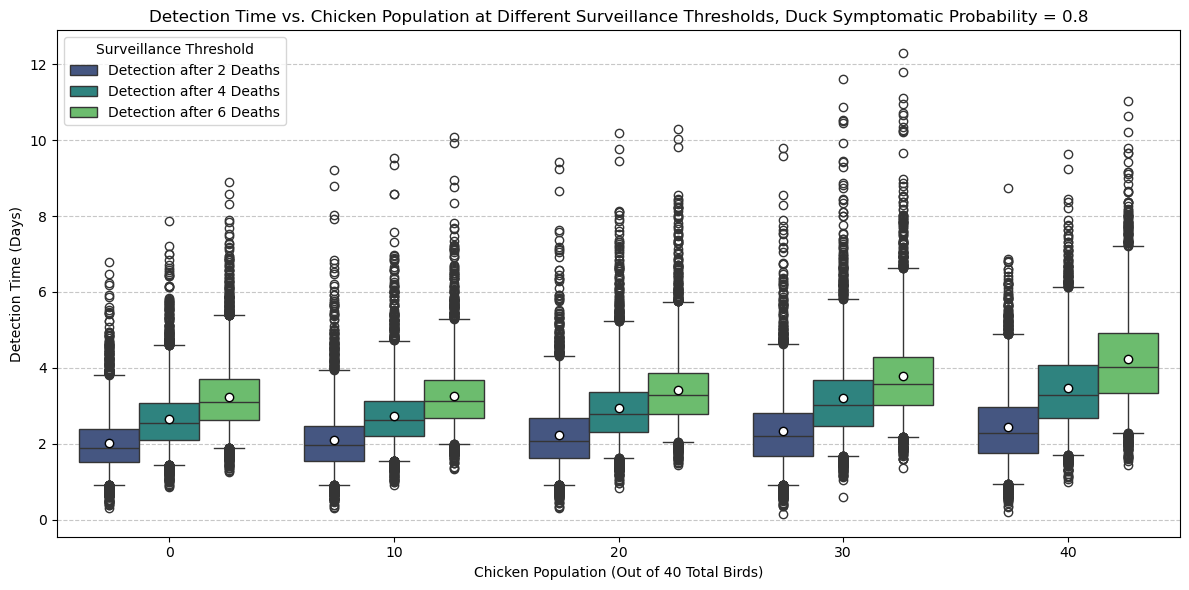

In [154]:
# Reshape the dataframe to long format for multiple thresholds
df_melted = df_all.melt(
    id_vars=["chicken_population"], 
    value_vars=["passive_surveillance_threshold_2", "passive_surveillance_threshold_4", "passive_surveillance_threshold_6"],
    var_name="Surveillance Threshold",
    value_name="Detection Time"
)

# Drop NaN values for visualization
df_melted = df_melted.dropna(subset=["Detection Time"])

# Map threshold names to more readable labels
threshold_labels = {
    "passive_surveillance_threshold_2": "Detection after 2 Deaths",
    "passive_surveillance_threshold_4": "Detection after 4 Deaths",
    "passive_surveillance_threshold_6": "Detection after 6 Deaths"
}
df_melted["Surveillance Threshold"] = df_melted["Surveillance Threshold"].map(threshold_labels)

# Plot the boxplot with custom whiskers
plt.figure(figsize=(12, 6))
sns.boxplot(
    x="chicken_population", 
    y="Detection Time", 
    hue="Surveillance Threshold",
    data=df_melted, 
    palette="viridis",
    whis=(2.5, 97.5),  # Set whiskers to 2.5th and 97.5th percentiles
    showmeans=True,
    meanprops={"marker": "o", "markerfacecolor": "white", "markeredgecolor": "black"}
)

# Labels and title
plt.xlabel("Chicken Population (Out of 40 Total Birds)")
plt.ylabel("Detection Time (Days)")
plt.title(f"Detection Time vs. Chicken Population at Different Surveillance Thresholds, Duck Symptomatic Probability = {symprob}")
plt.legend(title="Surveillance Threshold")
plt.grid(axis="y", linestyle="--", alpha=0.7)
# plt.ylim(0, 20)  # Optional y-axis limit

plt.tight_layout()
plt.show()




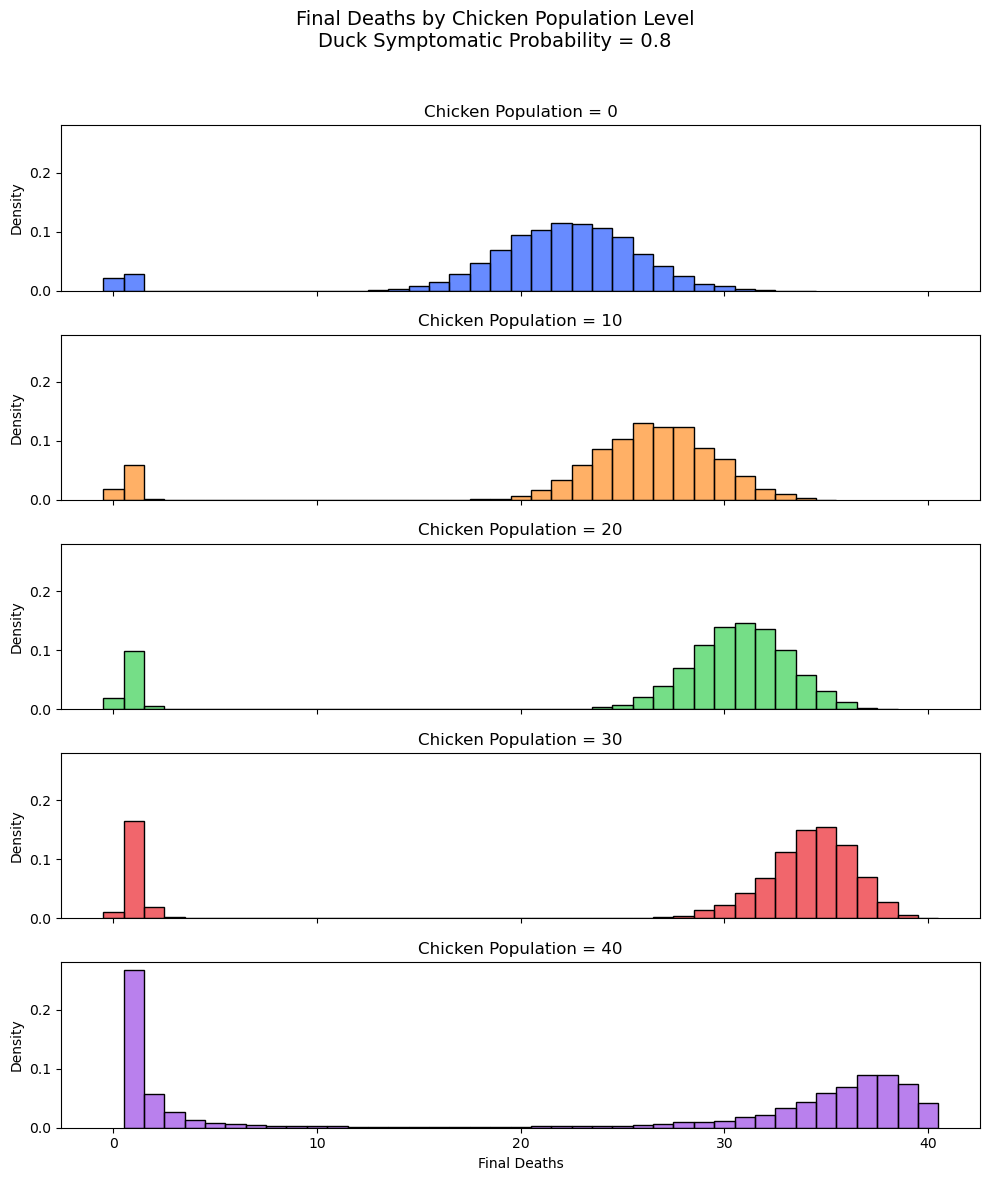

In [155]:
# Unique chicken population levels in desired order (top to bottom)
chicken_levels = [0, 10, 20, 30, 40]

# Create vertically stacked subplots
fig, axes = plt.subplots(nrows=len(chicken_levels), ncols=1, figsize=(10, 12), sharex=True)

max_density = 0  # To track max y-axis limit

# First pass: find max y-axis limit
for chicken in chicken_levels:
    subset = df_all[df_all["chicken_population"] == chicken]
    fig_tmp, ax_tmp = plt.subplots()
    sns.histplot(
        data=subset,
        x="final_deaths",
        bins=40,
        stat="density",
        discrete=True,
        alpha=0.6,
        color=sns.color_palette("bright")[chicken_levels.index(chicken)],
        ax=ax_tmp
    )
    # Extract heights of histogram bars from patches
    heights = [patch.get_height() for patch in ax_tmp.patches]
    if heights:
        max_density = max(max_density, max(heights))
    plt.close(fig_tmp)  # Close the temporary figure

# Second pass: plot with uniform y-axis limit
for i, chicken in enumerate(chicken_levels):
    ax = axes[i]
    subset = df_all[df_all["chicken_population"] == chicken]
    sns.histplot(
        data=subset,
        x="final_deaths",
        bins=40,
        stat="density",
        discrete=True,
        ax=ax,
        color=sns.color_palette("bright")[i],
        alpha=0.6
    )
    ax.set_title(f"Chicken Population = {chicken}")
    ax.set_ylabel("Density")
    ax.set_ylim(0, max_density * 1.05)  # Slightly bigger to avoid clipping

axes[-1].set_xlabel("Final Deaths")
plt.suptitle(f"Final Deaths by Chicken Population Level\nDuck Symptomatic Probability = {symprob}", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for suptitle
plt.show()


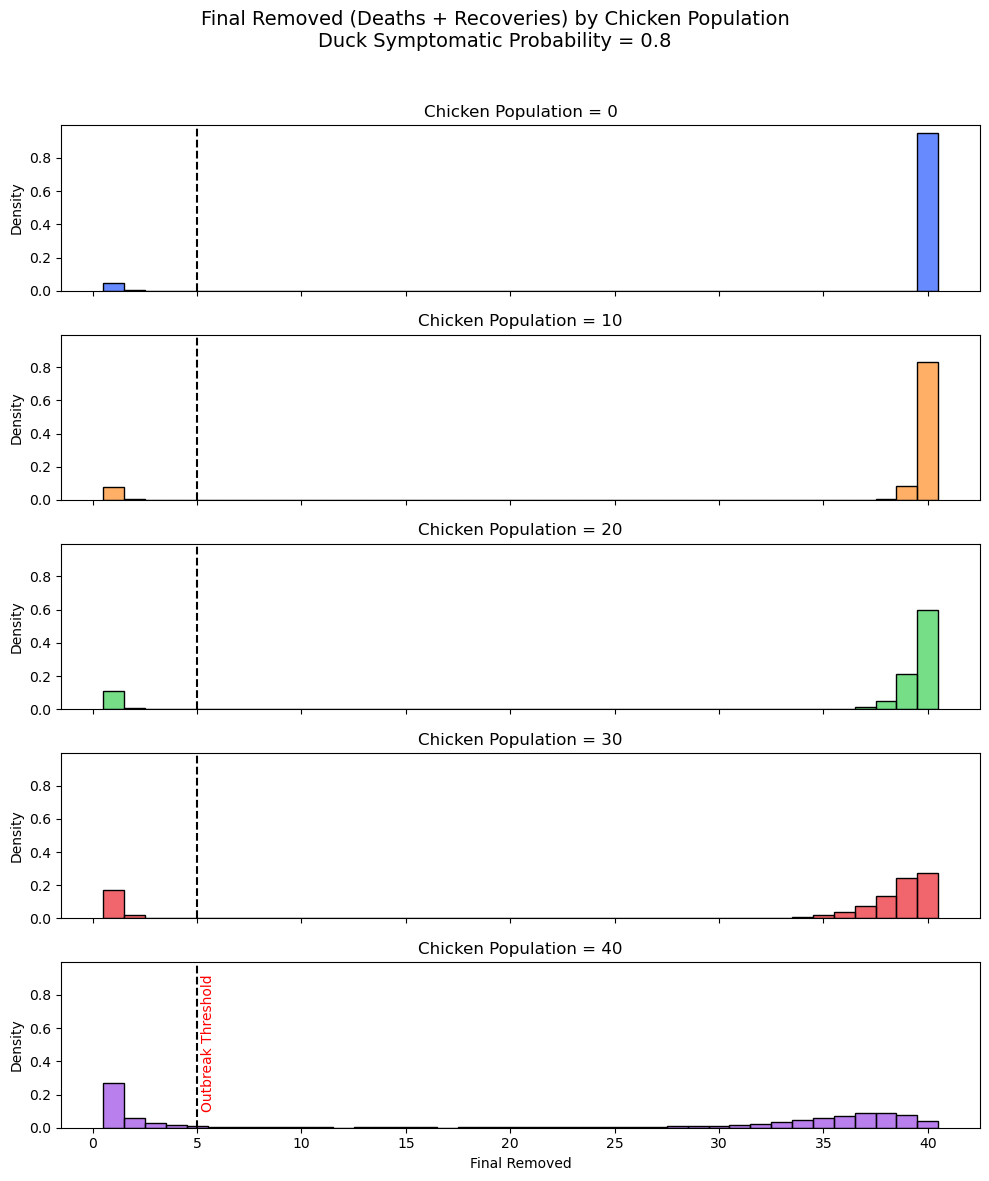

In [156]:
# Define chicken levels in desired order (top to bottom)
chicken_levels = [0, 10, 20, 30, 40]

# First pass: find max y-axis limit
max_density = 0
for chicken in chicken_levels:
    subset = df_all[df_all["chicken_population"] == chicken]
    fig_tmp, ax_tmp = plt.subplots()
    sns.histplot(
        data=subset,
        x="final_removed",
        bins=40,
        discrete=True,
        stat="density",
        alpha=0.6,
        color=sns.color_palette("bright")[chicken_levels.index(chicken)],
        ax=ax_tmp
    )
    heights = [patch.get_height() for patch in ax_tmp.patches]
    if heights:
        max_density = max(max_density, max(heights))
    plt.close(fig_tmp)

# Create subplots
fig, axes = plt.subplots(nrows=len(chicken_levels), ncols=1, figsize=(10, 12), sharex=True)

# Plot each subplot with uniform y-limit
for i, chicken in enumerate(chicken_levels):
    ax = axes[i]
    subset = df_all[df_all["chicken_population"] == chicken]
    
    sns.histplot(
        data=subset,
        x="final_removed",
        bins=40,
        discrete=True,
        stat="density",
        ax=ax,
        color=sns.color_palette("bright")[i],
        alpha=0.6
    )
    
    ax.axvline(x=5, color='k', linestyle='--')
    if i == len(chicken_levels) - 1:  # bottom plot only
        ax.text(5.2, max_density * 0.1, 'Outbreak Threshold',
                color='red', ha='left', va='bottom', rotation=90)
    
    ax.set_title(f"Chicken Population = {chicken}")
    ax.set_ylabel("Density")
    ax.set_ylim(0, max_density * 1.05)  # Add a little padding

# Common labels
axes[-1].set_xlabel("Final Removed")
plt.suptitle(f"Final Removed (Deaths + Recoveries) by Chicken Population\nDuck Symptomatic Probability = {symprob}", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


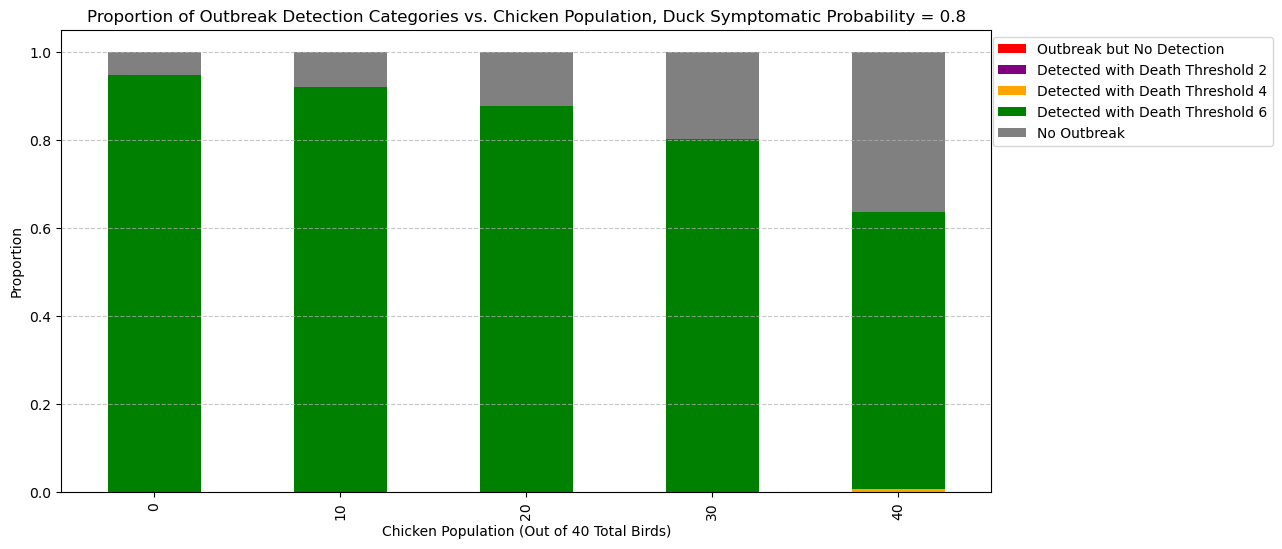

In [157]:
# Classify each simulation into five categories
df_all["outbreak_no_detection"] = (df_all["outbreak"] == True) & df_all[[
    "passive_surveillance_threshold_2", 
    "passive_surveillance_threshold_4", 
    "passive_surveillance_threshold_6"
]].isna().all(axis=1)

df_all["outbreak_and_detected_6"] = (df_all["outbreak"] == True) & df_all["passive_surveillance_threshold_6"].notna()
df_all["outbreak_and_detected_4"] = (df_all["outbreak"] == True) & df_all["passive_surveillance_threshold_4"].notna() & df_all["passive_surveillance_threshold_6"].isna()
df_all["outbreak_and_detected_2"] = (df_all["outbreak"] == True) & df_all["passive_surveillance_threshold_2"].notna() & df_all[[
    "passive_surveillance_threshold_4", 
    "passive_surveillance_threshold_6"
]].isna().all(axis=1)

df_all["no_outbreak"] = df_all["outbreak"] == False

# Group by chicken population and count occurrences of each category
category_counts = df_all.groupby("chicken_population")[[
    "outbreak_no_detection", 
    "outbreak_and_detected_2", 
    "outbreak_and_detected_4", 
    "outbreak_and_detected_6", 
    "no_outbreak"
]].sum()

# Normalize to get proportions
category_proportions = category_counts.div(category_counts.sum(axis=1), axis=0)

# Define colors for each category
colors = ["red", "purple", "orange", "green", "gray"]

# Create a segmented bar plot
category_proportions.plot(kind='bar', stacked=True, figsize=(12, 6), color=colors)

# Labels and title
plt.xlabel("Chicken Population (Out of 40 Total Birds)")
plt.ylabel("Proportion")
plt.title(f"Proportion of Outbreak Detection Categories vs. Chicken Population, Duck Symptomatic Probability = {symprob}")
plt.legend([
    "Outbreak but No Detection", 
    "Detected with Death Threshold 2", 
    "Detected with Death Threshold 4", 
    "Detected with Death Threshold 6", 
    "No Outbreak"
], bbox_to_anchor=(1.31, 1), loc="upper right")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()



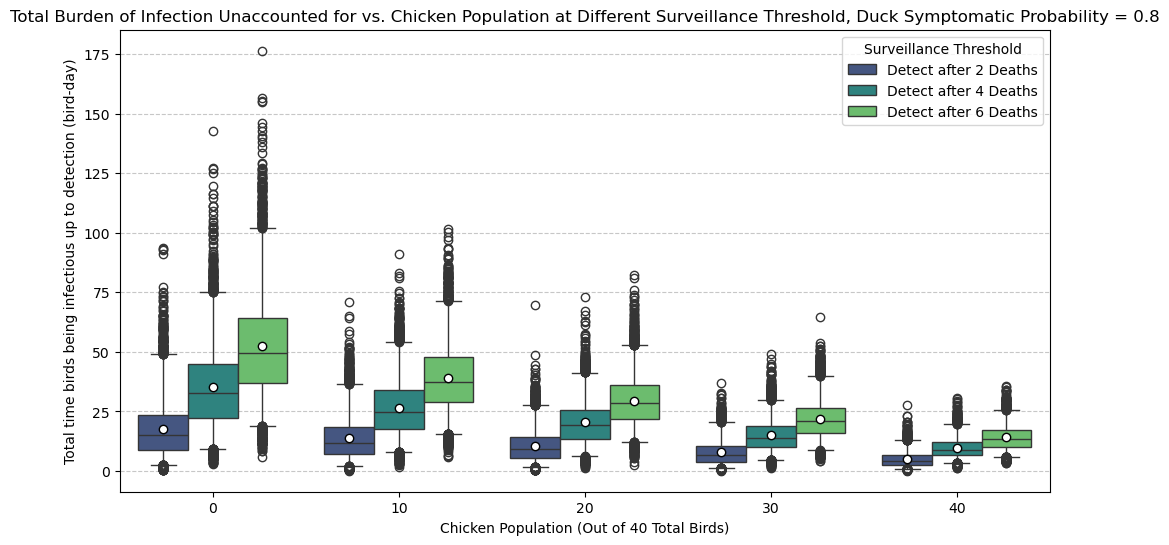

In [158]:
# Reshape the dataframe to long format for multiple thresholds
df_melted = df_all.melt(
    id_vars=["chicken_population"], 
    value_vars=["y2_state", "y4_state", "y6_state"],
    var_name="Surveillance Threshold",
    value_name="Detection Time"
)

# Drop NaN values for visualization
df_melted = df_melted.dropna(subset=["Detection Time"])

# Map threshold names to more readable labels
threshold_labels = {
    "y2_state": "Detect after 2 Deaths",
    "y4_state": "Detect after 4 Deaths",
    "y6_state": "Detect after 6 Deaths"
}
df_melted["Surveillance Threshold"] = df_melted["Surveillance Threshold"].map(threshold_labels)

# Plot the boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(
    x="chicken_population", 
    y="Detection Time", 
    hue="Surveillance Threshold",
    data=df_melted, 
    palette="viridis",
    whis=(2.5, 97.5),  # Set whiskers to 2.5th and 97.5th percentiles
    showmeans=True,
    meanprops={"marker": "o", "markerfacecolor": "white", "markeredgecolor": "black"},
)

# Labels and title
plt.xlabel("Chicken Population (Out of 40 Total Birds)")
plt.ylabel("Total time birds being infectious up to detection (bird-day)")
plt.title(f"Total Burden of Infection Unaccounted for vs. Chicken Population at Different Surveillance Threshold, Duck Symptomatic Probability = {symprob}")
plt.legend(title="Surveillance Threshold")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

In [159]:

# Parameter grids
chicken_levels = [0, 10, 20, 30, 40]
symptom_probs = [0.0, 0.2, 0.4, 0.6, 0.8]
rescale = 3.0
file_template = "Time_Series/chicken_{}_symprob_{}_rescale_{}.h5"

# Create a DataFrame to hold average final deaths
heatmap_data = pd.DataFrame(index=chicken_levels, columns=symptom_probs, dtype=float)

def read_final_deaths(output_file):
    try:
        with h5py.File(output_file, 'r') as f:
            total = 0
            count = 0
            for sim_name in f:
                if "state" in f[sim_name]:
                    state = f[sim_name]["state"][:]
                    final_deaths = np.sum(state[-1, :, :, 6:])
                    total += final_deaths
                    count += 1
            return total / count if count > 0 else np.nan
    except FileNotFoundError:
        print(f"Missing file: {output_file}")
        return np.nan

# Populate the heatmap data
for chicken in chicken_levels:
    for symprob in symptom_probs:
        output_file = file_template.format(chicken, symprob, rescale)
        avg_deaths = read_final_deaths(output_file)
        heatmap_data.loc[chicken, symprob] = avg_deaths

# (Optional) Convert column types to float
heatmap_data.columns = heatmap_data.columns.astype(float)

# Now you can use seaborn heatmap on `heatmap_data` if desired


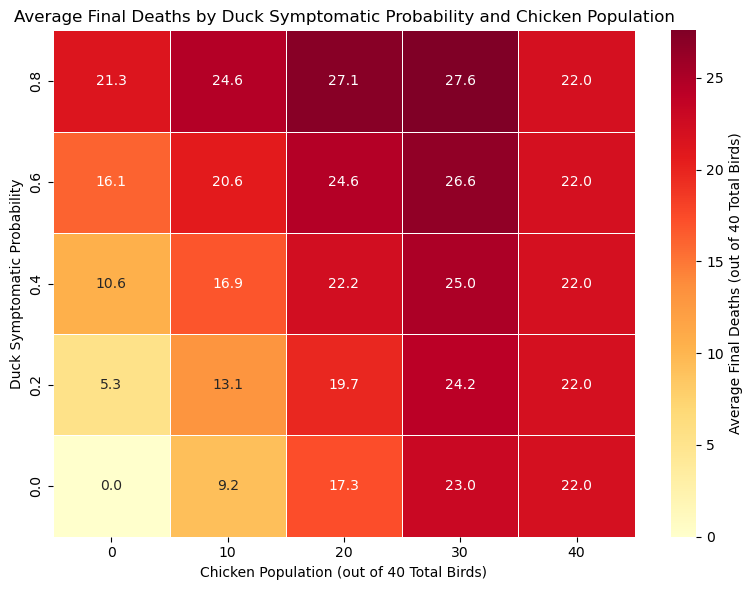

In [160]:
# Transpose the DataFrame to swap axes
heatmap_data_T = heatmap_data.T  # Now rows = symptom_probs, columns = chicken_levels

plt.figure(figsize=(8, 6))
sns.heatmap(
    heatmap_data_T,
    annot=True,
    fmt=".1f",
    cmap="YlOrRd",
    linewidths=0.5,
    cbar_kws={'label': 'Average Final Deaths (out of 40 Total Birds)'},
)

plt.title("Average Final Deaths by Duck Symptomatic Probability and Chicken Population")
plt.xlabel("Chicken Population (out of 40 Total Birds)")
plt.ylabel("Duck Symptomatic Probability")
plt.gca().invert_yaxis()  # Reverse the y-axis
plt.tight_layout()
plt.show()

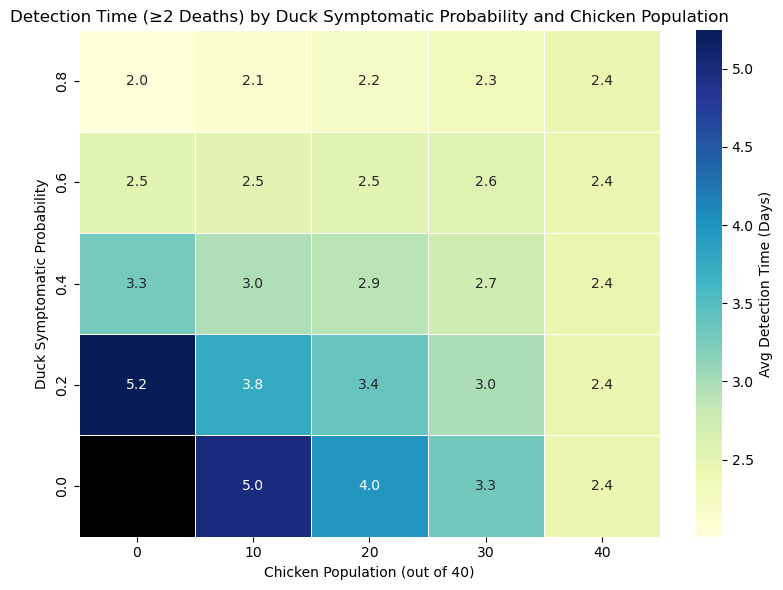

In [161]:

# Parameters
chicken_levels = [0, 10, 20, 30, 40]
symptom_probs = [0.0, 0.2, 0.4, 0.6, 0.8]
rescale = 3.0
threshold = 2  # deaths needed for detection
file_template = "Time_Series/chicken_{}_symprob_{}_rescale_{}.h5"

# DataFrame to hold detection times
heatmap_data = pd.DataFrame(index=chicken_levels, columns=symptom_probs, dtype=float)

# Function to compute detection time
def compute_detection_time(output_file, threshold):
    try:
        with h5py.File(output_file, 'r') as f:
            detection_times = []
            for sim_name in f:
                if "state" in f[sim_name]:
                    state = f[sim_name]["state"][:]  # shape: (T, x, y, C)
                    times = f[sim_name]["time"][:]
                    deaths = np.sum(state[:, :, :, 6], axis=(1, 2))  # deaths over time
                    detected = np.where(deaths >= threshold)[0]
                    if detected.size > 0:
                        detection_times.append(times[detected[0]])
            return np.mean(detection_times) if detection_times else np.nan
    except FileNotFoundError:
        print(f"Missing file: {output_file}")
        return np.nan

# Populate the heatmap data
for chicken in chicken_levels:
    for symprob in symptom_probs:
        output_file = file_template.format(chicken, symprob, rescale)
        avg_detection_time = compute_detection_time(output_file, threshold)
        heatmap_data.loc[chicken, symprob] = avg_detection_time

# Convert columns for seaborn compatibility
heatmap_data.columns = heatmap_data.columns.astype(float)

# Transpose: x = chicken, y = symptom prob
heatmap_data = heatmap_data.T

# Custom colormap for NaN
cmap = sns.color_palette("YlGnBu", as_cmap=True)
cmap.set_bad(color='#000000')  # Black for missing values

# Create mask for missing values
mask = heatmap_data.isna()

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".1f",
    cmap=cmap,
    mask=mask,
    linewidths=0.5,
    cbar_kws={'label': 'Avg Detection Time (Days)'}
)

plt.title(f"Detection Time (≥{threshold} Deaths) by Duck Symptomatic Probability and Chicken Population")
plt.xlabel("Chicken Population (out of 40)")
plt.ylabel("Duck Symptomatic Probability")
plt.gca().invert_yaxis()  # Reverse the y-axis
plt.tight_layout()
plt.show()




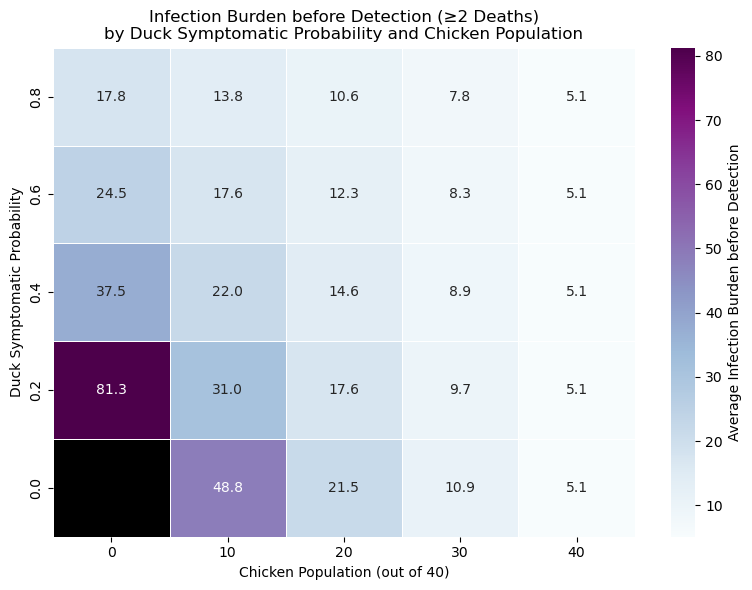

In [162]:
# Parameter setup
chicken_levels = [0, 10, 20, 30, 40]
symptom_probs = [0.0, 0.2, 0.4, 0.6, 0.8]
rescale = 3.0
threshold = 2
file_template = "Time_Series/chicken_{}_symprob_{}_rescale_{}.h5"

# Create DataFrame
burden_data = pd.DataFrame(index=symptom_probs, columns=chicken_levels, dtype=float)

# Compute burden function
def compute_burden(output_file, threshold):
    try:
        with h5py.File(output_file, 'r') as f:
            burdens = []
            for sim_name in f:
                if "state" in f[sim_name]:
                    y = f[sim_name]["state"][:]
                    t = f[sim_name]["time"][:]
                    cum_deaths = np.sum(y[:, :, :, 6], axis=(1, 2))
                    detect_idx = np.where(cum_deaths >= threshold)[0]
                    if detect_idx.size > 0:
                        stop = detect_idx[0] + 1
                        infectious = np.sum(y[:stop, :, :, 3:5], axis=(1, 2, 3))  # symptomatic + asymptomatic
                        burden = np.trapz(infectious, t[:stop])
                        burdens.append(burden)
            return np.mean(burdens) if burdens else np.nan
    except FileNotFoundError:
        print(f"Missing file: {output_file}")
        return np.nan

# Populate burden data
for chicken in chicken_levels:
    for symprob in symptom_probs:
        output_file = file_template.format(chicken, symprob, rescale)
        avg_burden = compute_burden(output_file, threshold)
        burden_data.loc[symprob, chicken] = avg_burden

# Colormap and NaN handling
cmap = sns.color_palette("BuPu", as_cmap=True)
cmap.set_bad(color='#000000')  # Black for missing values
mask = burden_data.isna()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    burden_data,
    annot=True,
    fmt=".1f",
    cmap=cmap,
    mask=mask,
    linewidths=0.5,
    cbar_kws={'label': 'Average Infection Burden before Detection'},
)

plt.title(f"Infection Burden before Detection (≥{threshold} Deaths)\nby Duck Symptomatic Probability and Chicken Population")
plt.xlabel("Chicken Population (out of 40)")
plt.ylabel("Duck Symptomatic Probability")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

